<a href="https://colab.research.google.com/github/sahillakhmani/Natural-Language-Processing/blob/main/Modified%20COALS%20Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Task (a) and (b)**

In [ ]:
import numpy as np
from collections import Counter
from multiprocessing import Pool, cpu_count
import h5py

# Parameters
VOCAB_SIZE = 7000
WINDOW_SIZE = 5
HDF5_FILE = "/content/drive/MyDrive/coals_data.h5"
CORPUS_PATH = '/content/drive/MyDrive/final_output.txt'

# Function to load the preprocessed corpus
def load_corpus(filepath):
    with open(filepath, 'r') as f:
        corpus = f.read().split()
    return corpus

# Step 1: Limit vocabulary size to the most frequent words
def build_vocabulary(corpus, vocab_size):
    word_counts = Counter(corpus)
    most_common = word_counts.most_common(vocab_size)
    vocab = {word: idx for idx, (word, _) in enumerate(most_common)}
    return vocab

# Step 2: Build the co-occurrence matrix for a chunk of the corpus
def cooccurrence_matrix_for_chunk(chunk, vocab, window_size):
    vocab_size = len(vocab)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float64)

    chunk_length = len(chunk)
    for i, word in enumerate(chunk):
        if word in vocab:
            word_idx = vocab[word]
            start = max(0, i - window_size)
            end = min(chunk_length, i + window_size + 1)
            for j in range(start, end):
                if i != j and chunk[j] in vocab:
                    context_idx = vocab[chunk[j]]
                    co_matrix[word_idx, context_idx] += 1

    return co_matrix

# Helper function to process each chunk with multiprocessing
def process_chunk(chunk_data):
    chunk, vocab, window_size = chunk_data
    return cooccurrence_matrix_for_chunk(chunk, vocab, window_size)

# Multiprocessing step to handle large corpus
def compute_cooccurrence_parallel(corpus, vocab, window_size, num_workers=None):
    if num_workers is None:
        num_workers = cpu_count()

    # Split corpus into chunks for parallel processing
    chunk_size = len(corpus) // num_workers
    chunks = [corpus[i:i + chunk_size] for i in range(0, len(corpus), chunk_size)]

    # Preparing data to be sent to each worker
    chunk_data = [(chunk, vocab, window_size) for chunk in chunks]

    with Pool(num_workers) as pool:
        print("Starting co-occurrence matrix computation...")
        results = pool.map(process_chunk, chunk_data)

    final_matrix = np.sum(results, axis=0)
    print("Co-occurrence matrix computation completed.")
    return final_matrix

# Step 3: Calculate probabilities P_ij
def calculate_probabilities(co_matrix):
    row_sums = np.sum(co_matrix, axis=1, keepdims=True)
    prob_matrix = np.divide(co_matrix, row_sums, where=row_sums != 0)  # Avoid division by zero
    return prob_matrix

# Step 4: Compute probability ratios P_ik / P_jk for a specific word k
def compute_probability_ratios(prob_matrix, word_k_idx):
    print(f"Computing probability ratios P_ik / P_jk for word index {word_k_idx}...")

    # Get the probability vector for the 3500th word (w_k)
    prob_vector_k = prob_matrix[:, word_k_idx]

    # Compute the ratio matrix P_ik / P_jk for all words i and j
    ratio_matrix = np.divide(prob_vector_k[:, np.newaxis], prob_vector_k, where=(prob_vector_k != 0))

    print("Probability ratios computation completed.")
    return ratio_matrix

# Main function
def main():
    # Load the corpus
    filepath = CORPUS_PATH
    print("Loading corpus...")
    corpus = load_corpus(filepath)
    print(f"Corpus loaded. Size: {len(corpus)} words.")

    # Build the vocabulary of the top 7000 most frequent words
    print("Building vocabulary...")
    vocab = build_vocabulary(corpus, VOCAB_SIZE)
    print(f"Vocabulary built. Size: {len(vocab)} words.")

    # Compute the co-occurrence matrix using multiprocessing
    co_matrix = compute_cooccurrence_parallel(corpus, vocab, WINDOW_SIZE)

    # Calculate the probabilities for all words
    print("Calculating probabilities for all words...")
    prob_matrix = calculate_probabilities(co_matrix)

    # Select word w_k as the 3500th word from the vocabulary
    word_k_idx = VOCAB_SIZE // 2

    # Compute the ratio of probabilities P_ik / P_jk for all i and j
    ratio_matrix = compute_probability_ratios(prob_matrix, word_k_idx)

    # Save the ratio matrix to HDF5
    with h5py.File(HDF5_FILE, 'a') as f:
        f.create_dataset(f"ratio_matrix_for_word_{word_k_idx}", data=ratio_matrix)

    print(f"Results saved in {HDF5_FILE}.")
    print("Program completed.")

if __name__ == "__main__":
    main()

Loading corpus...
Corpus loaded. Size: 61908120 words.
Building vocabulary...
Vocabulary built. Size: 7000 words.
Starting co-occurrence matrix computation...
Co-occurrence matrix computation completed.
Calculating probabilities for all words...
Computing probability ratios P_ik / P_jk for word index 3500...
Probability ratios computation completed.
Results saved in /content/drive/MyDrive/coals_data.h5.
Program completed.


# **Task (c)**

In [ ]:
import h5py

# Path to the HDF5 file
HDF5_FILE = "/content/drive/MyDrive/coals_data.h5"

def display_hdf5_info(hdf5_file):
    # Open the HDF5 file in read mode
    with h5py.File(hdf5_file, 'r') as f:

        # Display available ratio matrix (for a specific word)
        for key in f.keys():
            if key.startswith("ratio_matrix_for_word_"):
                ratio_matrix = f[key]
                print(f"Co-occurence matrix size: {ratio_matrix.shape}")
                vocab_size = ratio_matrix.shape[0]  # Assuming square matrices (7000x7000)
                print(f"Vocabulary Size: {vocab_size}")


# Call the function to display the matrix information
display_hdf5_info(HDF5_FILE)


Co-occurence matrix size: (7000, 7000)
Vocabulary Size: 7000


# **Task (d)**

In [ ]:
import h5py
from collections import Counter
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# File path details
CORPUS_PATH = '/content/drive/MyDrive/final_output.txt'
VOCAB_FILE = 'vocab_with_frequencies.h5'

# Function to load the corpus
def load_corpus(filepath):
    with open(filepath, 'r') as f:
        return f.read()

# Function to build the vocabulary with frequencies
def build_vocabulary(corpus, vocab_size=7000):
    word_counts = Counter(corpus.split())
    most_common = word_counts.most_common(vocab_size)
    vocab = {word: (idx, count) for idx, (word, count) in enumerate(most_common)}
    return vocab

# Function to save vocabulary with frequencies to HDF5 file
def save_vocabulary_with_frequencies(vocab, hdf5_file):
    with h5py.File(hdf5_file, 'w') as f:
        vocab_group = f.create_group("vocabulary")
        for word, (idx, count) in vocab.items():
            vocab_group.create_dataset(word, data=[idx, count])

# Load the preprocessed corpus
print("Loading preprocessed corpus from Drive...")
corpus = load_corpus(CORPUS_PATH)

# Build the vocabulary from the corpus
vocab = build_vocabulary(corpus)

# Save the vocabulary with frequencies to an HDF5 file
save_vocabulary_with_frequencies(vocab, VOCAB_FILE)

OUTPUT_FILE = 'nouns_verbs.txt'

# Function to load the corpus
def load_corpus(filepath):
    with open(filepath, 'r') as f:
        return f.read()

# Function to build the vocabulary with frequencies
def build_vocabulary(corpus, vocab_size=7000):
    word_counts = Counter(corpus.split())
    most_common = word_counts.most_common(vocab_size)
    vocab = {word: (idx, count) for idx, (word, count) in enumerate(most_common)}
    return vocab

# Function to identify nouns and verbs from the vocabulary using spaCy
def identify_nouns_verbs(vocab):
    nouns = []
    verbs = []

    for word in vocab:
        doc = nlp(word)
        for token in doc:
            if token.pos_ == 'NOUN' and len(nouns) < 5:
                nouns.append(word)
            elif token.pos_ == 'VERB' and len(verbs) < 5:
                verbs.append(word)
        if len(nouns) >= 5 and len(verbs) >= 5:
            break
    return nouns, verbs

# Function to save nouns and verbs to a text file
def save_nouns_verbs(nouns, verbs, filepath):
    with open(filepath, 'w') as f:
        f.write("Nouns:\n")
        f.write("\n".join(nouns))
        f.write("\n\nVerbs:\n")
        f.write("\n".join(verbs))


# Identify nouns and verbs
nouns, verbs = identify_nouns_verbs(vocab)

# Print the nouns and verbs
print("Nouns:", nouns)
print("Verbs:", verbs)

# Save the nouns and verbs to a text file
save_nouns_verbs(nouns, verbs, OUTPUT_FILE)

print(f"Nouns and verbs saved to {OUTPUT_FILE}.")



Loading preprocessed corpus from Drive...
Nouns: ['patients', 'cells', 'covid', 'virus', 'data']
Verbs: ['study', 'using', 'used', 'use', 'reported']
Nouns and verbs saved to nouns_verbs.txt.


# **Task (e)**

In [ ]:
import h5py
import numpy as np

# File paths
COOCCURRENCE_MATRIX_FILE = '/content/drive/MyDrive/coals_data.h5'
NOUNS_VERBS_FILE = '/content/nouns_verbs.txt'
OUTPUT_FILE = '/content/similar_words.txt'

# Load the co-occurrence matrix
def load_cooccurrence_matrix(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        co_matrix = f['ratio_matrix_for_word_3500'][:]  # Change the dataset name if needed
    return co_matrix

# Function to calculate cosine distance using 1 - (||u - v||^2 / 2)
def calculate_cosine_distance(matrix, word_idx):
    target_vector = matrix[word_idx]

    # Calculate squared Euclidean distances from target_vector to all other vectors
    squared_diff = np.sum((matrix - target_vector) ** 2, axis=1)

    # Calculate cosine distance
    cosine_distance = 1 - (squared_diff / 2)

    return cosine_distance

# Load the nouns and verbs
def load_nouns_verbs(filepath):
    with open(filepath, 'r') as f:
        words = f.read().splitlines()
    return words

# Function to find the top 5 similar words based on cosine distance
def find_similar_words(vocab_list, matrix, word, vocab_dict, top_n=5):
    if word not in vocab_dict:
        return []

    word_idx = vocab_dict[word]
    distances = calculate_cosine_distance(matrix, word_idx)

    # Exclude the word itself by setting its distance to -inf (cosine distance would be maximum)
    distances[word_idx] = -np.inf

    # Get the indices of the top 5 closest words (largest distances)
    top_indices = np.argsort(distances)[-top_n:][::-1]

    similar_words = [(vocab_list[idx], distances[idx]) for idx in top_indices]
    return similar_words

# Load the vocabulary and co-occurrence matrix
print("Loading co-occurrence matrix...")
cooccurrence_matrix = load_cooccurrence_matrix(COOCCURRENCE_MATRIX_FILE)

# Assume vocab_list and vocab_dict are derived from the same vocabulary used to build the co-occurrence matrix
vocab_list = list(vocab.keys())  # Assuming 'vocab' is available from the previous context
vocab_dict = {word: idx for idx, word in enumerate(vocab_list)}

# Load nouns and verbs
print("Loading nouns and verbs...")
nouns_verbs = load_nouns_verbs(NOUNS_VERBS_FILE)

# Find and display similar words
print("Finding similar words based on cosine distance...")
with open(OUTPUT_FILE, 'w') as f_out:
    for word in nouns_verbs:
        similar_words = find_similar_words(vocab_list, cooccurrence_matrix, word, vocab_dict)
        if similar_words:
            print(f"Similar words for '{word}':")
            f_out.write(f"Similar words for '{word}':\n")
            for similar_word, distance in similar_words:
                print(f"{similar_word}: {distance}")
                f_out.write(f"{similar_word}: {distance}\n")
            print("\n")
            f_out.write("\n")

print(f"Similar words have been saved to {OUTPUT_FILE}.")


Loading co-occurrence matrix...
Loading nouns and verbs...
Finding similar words based on cosine distance...
Similar words for 'patients':
sought: 0.9981230610243619
ahead: 0.9945533076609424
ignored: 0.991518755989788
continue: 0.9635189187693768
minority: 0.9514920692741284


Similar words for 'cells':
cancer: 0.9999974840042554
intervention: 0.9995189047019061
government: 0.9986596737329173
fusion: 0.9833550727120733
peptide: 0.9723714163673701


Similar words for 'covid':
frequencies: 0.9988370492137987
consistently: 0.9966708418506558
entities: 0.9924832088335893
appear: 0.986666176101029
departments: 0.9866212454007681


Similar words for 'virus':
demonstration: 0.9824361007305897
purchased: 0.9816007958785122
persistence: 0.5460376032017947
encephalitis: -0.11859414567302595
monkeys: -1.4836089680643685


Similar words for 'data':
host: 0.99904160605853
program: 0.998889519893873
states: 0.9988412170186557
vary: 0.9987000242715816
reproduction: 0.998334468161543


Similar words 

# **Task (f)**

Loading ratio matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


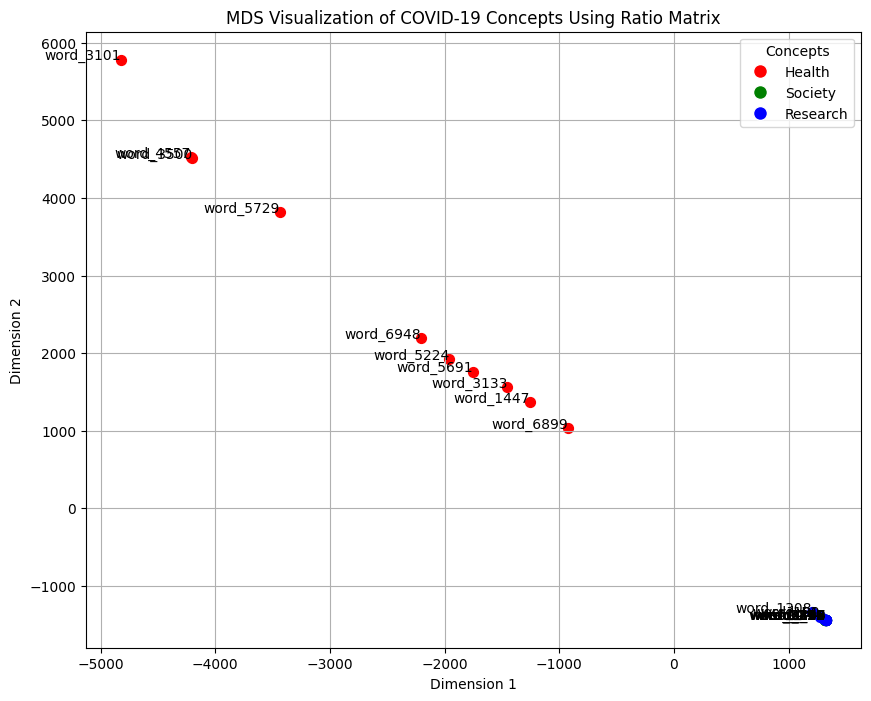

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import h5py

# Load the ratio matrix from the HDF5 file
def load_ratio_matrix(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        ratio_matrix = f['ratio_matrix_for_word_3500'][:]  # Adjust dataset name as needed
    return ratio_matrix

# Find the most relevant words based on the ratio matrix
def find_relevant_words(matrix, vocab_list, num_words=10):
    word_indices = np.argsort(-matrix.sum(axis=1))[:num_words]
    return [vocab_list[i] for i in word_indices]

# Load your vocabulary list (make sure it's in the same order as when you built the matrix)
vocab_list = [f"word_{i}" for i in range(7000)]  # Replace with your actual vocabulary list

# Load the ratio matrix
print("Loading ratio matrix...")
ratio_matrix = load_ratio_matrix('/content/drive/MyDrive/coals_data.h5')

# Find the most relevant words for each concept
num_words_per_concept = 10  # Adjust as needed
health_words = find_relevant_words(ratio_matrix, vocab_list, num_words=num_words_per_concept)
society_words = find_relevant_words(ratio_matrix.T, vocab_list, num_words=num_words_per_concept)
research_words = find_relevant_words(ratio_matrix, vocab_list[::-1], num_words=num_words_per_concept)

# Combine all selected words
all_words = health_words + society_words + research_words
all_indices = [vocab_list.index(word) for word in all_words]

# Create a similarity matrix for the selected words
similarity_matrix = ratio_matrix[np.ix_(all_indices, all_indices)]

# Convert similarity to distance (1 - similarity)
distance_matrix = 1 - similarity_matrix

# Apply MDS
mds = MDS(n_components=2, random_state=42)
pos = mds.fit_transform(distance_matrix)

# Assign colors to each concept
concept_colors = ['red'] * len(health_words) + ['green'] * len(society_words) + ['blue'] * len(research_words)

# Plot the results with color coding
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(pos):
    plt.scatter(x, y, color=concept_colors[i], label=all_words[i] if i == 0 else "", s=50)  # Use label only once per color for legend
    plt.annotate(all_words[i], (x, y), fontsize=10, ha='right')

# Create a legend for the color-coded concepts
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Health'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Society'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Research')
]
plt.legend(handles=handles, title="Concepts", loc="upper right")

plt.title("MDS Visualization of COVID-19 Concepts Using Ratio Matrix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()